In [3]:
import numpy as np
import pandas as pd
import pymysql
import json

In [4]:
def get_mysql_credentials():
        with open("mysql_config.json", "r") as jsonfile:
            data = json.load(jsonfile)
        return (data['host'], data['user'], data['password'], data['database'])
    
def get_cursor():
    creds = get_mysql_credentials()
    dbinstance_endpoint = creds[0]
    db_username = creds[1]
    db_pw = creds[2]
    db_name = creds[3]
    connection = pymysql.connect(host = dbinstance_endpoint, user = db_username, password = db_pw, database = db_name, autocommit=True)
    cursor = connection.cursor()
    return cursor

cursor = get_cursor()

In [6]:
import ast
from datetime import datetime, timedelta, date

In [11]:
import bisect

In [55]:
def calc_orderboook_imb(bids, asks, level=1):
    '''
    bids: ascending [price, qty] list
    asks: ascending [price, qty] list
    level: depth of orderbook for which to calculate order book imbalance
    '''
    bids_depth = len(bids)
    asks_depth = len(asks)
    if level > min([bids_depth, asks_depth]):
        return calc_orderboook_imb(bids, asks, min([bids_depth, asks_depth]))
    else:
        bids_vol = 0
        asks_vol = 0
        for idx in range(level):
            bids_vol += bids[len(bids)-1-idx][1]
            asks_vol += asks[idx][1]
        return (bids_vol - asks_vol)/(bids_vol + asks_vol)

In [66]:
def get_best_bid(bids):
    '''
    bids: ascending [price, qty] list
    '''
    if len(bids):
        return bids[len(bids)-1][0]
    else:
        return 0

def get_best_ask(asks):
    '''
    asks: ascending [price, qty] list
    '''
    if len(asks):
        return asks[0][0]
    else:
        return np.inf

    

In [67]:
def update_bids(bids, price, delta):
    '''
    bids: ascending [price, qty] list
    price: price level at which delta qty is being added to or removed
    delta: contracts being placed or removed from a price level
    '''
    bisect_left_ip = bisect.bisect_left(bids, price, key = lambda x: x[0])
    if bisect_left_ip == len(bids):
        #price is greater than all of the bids
        assert delta > 0
        bids.insert(bisect_left_ip, [price, delta])
        
    else:
        #price is greater than bids[:bisect_left_ip]
        if bids[bisect_left_ip][0] == price:
            #price exists in the current bids
            bids[bisect_left_ip][1]+=delta #update qty
            if bids[bisect_left_ip][1] <= 0:
                #remove price leveel
                del bids[bisect_left_ip]
        else:
            #price does not exist in the current bids
            assert delta > 0
            bids.insert(bisect_left_ip, [price, delta])

def update_asks(asks, price, delta):
    '''
    asks: ascending [price, qty] list
    price: price level at which delta qty is being added to or removed
    delta: contracts being placed or removed from a price level
    '''
    bisect_left_ip = bisect.bisect_left(asks, price, key = lambda x: x[0])
    if bisect_left_ip == len(asks):
        #price is greater than all of the asks
        assert delta > 0
        asks.insert(bisect_left_ip, [price, delta])
        
    else:
        #price is greater than asks[:bisect_left_ip]
        if asks[bisect_left_ip][0] == price:
            #price exists in the current bids
            asks[bisect_left_ip][1]+=delta #update qty
            if asks[bisect_left_ip][1] <= 0:
                #remove price leveel
                del asks[bisect_left_ip]
        else:
            #price does not exist in the current bids
            assert delta > 0
            asks.insert(bisect_left_ip, [price, delta])
    
            
    

In [68]:
'''
For a given date, NASDAQ ticker, and SP500 ticker, the code in this cell computes the best bid, best ask
, midprice, and orderbook imbalance up to a depth of 4 at a timestamp corresponding to an orderbook event for
that ticker. This data is represented in a dataframe named data.
'''


nasdaq_ob = {}
sp500_ob = {}
data_dict = {'best_bid': [], 'best_ask': [], 'obi_l1': [], 'obi_l2': [], 'obi_l3': [], 'obi_l4': [], 'ticker': [], 'timestamp': []}
date = '2024-01-29'
nasdaq_ticker = 'NASDAQ100-24JAN29-B17550'
sp500_ticker = 'INX-24JAN29-B4937'

#handle NASDAQ orderbook snapshot
cursor.execute('select * from ob_snapshot where market_ticker = \'{}\' and processed_ts like \'%{}%\''.format(nasdaq_ticker, date))
row = cursor.fetchall()[0]
bids_dict = ast.literal_eval(row[3])
bids = [] #will be sorted list in desc order of len-2 lists where 1st el is price and 2nd is qty
asks_dict = ast.literal_eval(row[4])
asks = [] ##will be sorted list in asc order of len-2 lists where 1st el is price and 2nd is qty
processed_ts = datetime.strptime(row[5], '%Y-%m-%dT%H:%M:%S.%fZ')




if bids_dict is not None:
    for p, q in bids_dict.items():
        bids.append([p, q])
    nasdaq_ob['bids'] = bids[:]
    nasdaq_ob['bids'].sort(key = lambda x: x[0])

else:
    nasdaq_ob['bids'] = bids[:]
if asks_dict is not None:
    for p, q in asks_dict.items():
        asks.append([p, q])
    nasdaq_ob['asks'] = asks[:]
    nasdaq_ob['asks'].sort(key = lambda x: x[0])
else:
    nasdaq_ob['asks'] = asks[:]
    


data_dict['best_bid'].append(get_best_bid(nasdaq_ob['bids']))
data_dict['best_ask'].append(get_best_ask(nasdaq_ob['asks']))
data_dict['obi_l1'].append(calc_orderboook_imb(nasdaq_ob['bids'], nasdaq_ob['asks'], 1))
data_dict['obi_l2'].append(calc_orderboook_imb(nasdaq_ob['bids'], nasdaq_ob['asks'], 2))
data_dict['obi_l3'].append(calc_orderboook_imb(nasdaq_ob['bids'], nasdaq_ob['asks'], 3))
data_dict['obi_l4'].append(calc_orderboook_imb(nasdaq_ob['bids'], nasdaq_ob['asks'], 4))
data_dict['ticker'].append(nasdaq_ticker)
data_dict['timestamp'].append(processed_ts)


#handle NASDAQ orderbook deltas

cursor.execute('select seq_num, price, delta, side, processed_ts from ob_delta where market_ticker = \'{}\' and processed_ts like \'%{}%\' ORDER BY seq_num ASC'.format(nasdaq_ticker, date))
rows = cursor.fetchall()
for row in rows:
    price = row[1]
    delta = row[2]
    side = row[3]
    processed_ts = row[4]
    
    if side == 'yes':
        update_bids(nasdaq_ob['bids'], price, delta)
    else:
        update_asks(nasdaq_ob['asks'], price, delta)
    
    data_dict['best_bid'].append(get_best_bid(nasdaq_ob['bids']))
    data_dict['best_ask'].append(get_best_ask(nasdaq_ob['asks']))
    data_dict['obi_l1'].append(calc_orderboook_imb(nasdaq_ob['bids'], nasdaq_ob['asks'], 1))
    data_dict['obi_l2'].append(calc_orderboook_imb(nasdaq_ob['bids'], nasdaq_ob['asks'], 2))
    data_dict['obi_l3'].append(calc_orderboook_imb(nasdaq_ob['bids'], nasdaq_ob['asks'], 3))
    data_dict['obi_l4'].append(calc_orderboook_imb(nasdaq_ob['bids'], nasdaq_ob['asks'], 4))
    data_dict['ticker'].append(nasdaq_ticker)
    data_dict['timestamp'].append(processed_ts)



#handle SP500 orderbook snapshot

cursor.execute('select * from ob_snapshot where market_ticker = \'{}\' and processed_ts like \'%{}%\''.format(sp500_ticker, date))
row = cursor.fetchall()[0]
bids_dict = ast.literal_eval(row[3])
bids = [] #will be sorted list in desc order of len-2 lists where 1st el is price and 2nd is qty
asks_dict = ast.literal_eval(row[4])
asks = [] ##will be sorted list in asc order of len-2 lists where 1st el is price and 2nd is qty
processed_ts = datetime.strptime(row[5], '%Y-%m-%dT%H:%M:%S.%fZ')


if bids_dict is not None:
    for p, q in bids_dict.items():
        bids.append([p, q])
    sp500_ob['bids'] = bids[:]
    sp500_ob['bids'].sort(key = lambda x: x[0])

else:
    sp500_ob['bids'] = bids[:]
if asks_dict is not None:
    for p, q in asks_dict.items():
        asks.append([p, q])
    sp500_ob['asks'] = asks[:]
    sp500_ob['asks'].sort(key = lambda x: x[0])
else:
    sp500_ob['asks'] = asks[:]
    

data_dict['best_bid'].append(get_best_bid(sp500_ob['bids']))
data_dict['best_ask'].append(get_best_ask(sp500_ob['asks']))
data_dict['obi_l1'].append(calc_orderboook_imb(sp500_ob['bids'], sp500_ob['asks'], 1))
data_dict['obi_l2'].append(calc_orderboook_imb(sp500_ob['bids'], sp500_ob['asks'], 2))
data_dict['obi_l3'].append(calc_orderboook_imb(sp500_ob['bids'], sp500_ob['asks'], 3))
data_dict['obi_l4'].append(calc_orderboook_imb(sp500_ob['bids'], sp500_ob['asks'], 4))
data_dict['ticker'].append(sp500_ticker)
data_dict['timestamp'].append(processed_ts)

#handle SP500 orderbook deltas

cursor.execute('select price, delta, side, processed_ts from ob_delta where market_ticker = \'{}\' and processed_ts like \'%{}%\' ORDER BY seq_num ASC'.format(sp500_ticker
, date))
rows = cursor.fetchall()
for row in rows:
    price = row[0]
    delta = row[1]
    side = row[2]
    processed_ts = row[3]
    
    if side == 'yes':
        update_bids(sp500_ob['bids'], price, delta)
    else:
        update_asks(sp500_ob['asks'], price, delta)
    
    data_dict['best_bid'].append(get_best_bid(sp500_ob['bids']))
    data_dict['best_ask'].append(get_best_ask(sp500_ob['asks']))
    data_dict['obi_l1'].append(calc_orderboook_imb(sp500_ob['bids'], sp500_ob['asks'], 1))
    data_dict['obi_l2'].append(calc_orderboook_imb(sp500_ob['bids'], sp500_ob['asks'], 2))
    data_dict['obi_l3'].append(calc_orderboook_imb(sp500_ob['bids'], sp500_ob['asks'], 3))
    data_dict['obi_l4'].append(calc_orderboook_imb(sp500_ob['bids'], sp500_ob['asks'], 4))
    data_dict['ticker'].append(sp500_ticker)
    data_dict['timestamp'].append(processed_ts)

data = pd.DataFrame(data_dict)

/var/folders/8r/fr9y19j57554vvz5607f_l4h0000gn/T/ipykernel_82819/4173086383.py:147: FutureWarning: Inferring datetime64[ns, UTC] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns, UTC])
  data = pd.DataFrame(data_dict)


In [71]:
data.head(20)

,best_bid,best_ask,obi_l1,obi_l2,obi_l3,obi_l4,ticker,timestamp
0,72,78,0.000000,-0.428571,-0.500000,-0.500000,NASDAQ100-24JAN29-B17550,2024-01-29 20:15:48.068860+00:00
1,72,78,0.000000,-0.200000,-0.400000,-0.444444,NASDAQ100-24JAN29-B17550,2024-01-29 20:15:51.198075+00:00
2,72,78,0.000000,-0.200000,-0.400000,-0.444444,NASDAQ100-24JAN29-B17550,2024-01-29 20:15:51.198121+00:00
3,72,78,0.000000,-0.200000,-0.400000,-0.444444,NASDAQ100-24JAN29-B17550,2024-01-29 20:15:54.219404+00:00
4,72,78,-0.500000,-0.428571,-0.500000,-0.500000,NASDAQ100-24JAN29-B17550,2024-01-29 20:15:54.220695+00:00
5,72,78,-0.512195,-0.436620,-0.504132,-0.502488,NASDAQ100-24JAN29-B17550,2024-01-29 20:15:54.296569+00:00
6,72,78,-0.500000,-0.428571,-0.500000,-0.500000,NASDAQ100-24JAN29-B17550,2024-01-29 20:15:54.336010+00:00
7,72,78,-0.500000,-0.428571,-0.500000,-0.500000,NASDAQ100-24JAN29-B17550,2024-01-29 20:15:57.202272+00:00
8,72,78,-0.500000,-0.428571,-0.500000,-0.428571,NASDAQ100-24JAN29-B17550,2024-01-29 20:15:57.202292+00:00
9,72,78,-0.500000,-0.428571,-0.285714,-0.497753,NASDAQ100-24JAN29-B17550,2024-01-29 20:15:57.202313+00:00


In [72]:
data['midpoint'] = data.apply(lambda x: (x['best_bid']+x['best_ask'])/2, axis=1)

In [73]:
data

,best_bid,best_ask,obi_l1,obi_l2,obi_l3,obi_l4,ticker,timestamp,midpoint
0,72,78,0.000000,-0.428571,-0.500000,-0.500000,NASDAQ100-24JAN29-B17550,2024-01-29 20:15:48.068860+00:00,75.0
1,72,78,0.000000,-0.200000,-0.400000,-0.444444,NASDAQ100-24JAN29-B17550,2024-01-29 20:15:51.198075+00:00,75.0
2,72,78,0.000000,-0.200000,-0.400000,-0.444444,NASDAQ100-24JAN29-B17550,2024-01-29 20:15:51.198121+00:00,75.0
3,72,78,0.000000,-0.200000,-0.400000,-0.444444,NASDAQ100-24JAN29-B17550,2024-01-29 20:15:54.219404+00:00,75.0
4,72,78,-0.500000,-0.428571,-0.500000,-0.500000,NASDAQ100-24JAN29-B17550,2024-01-29 20:15:54.220695+00:00,75.0
...,...,...,...,...,...,...,...,...,...
22029,55,62,0.326599,-0.200000,-0.114827,-0.169591,INX-24JAN29-B4937,2024-01-29 20:56:12.103928+00:00,58.5
22030,55,62,0.326599,-0.200000,-0.114827,-0.169591,INX-24JAN29-B4937,2024-01-29 20:56:12.103991+00:00,58.5
22031,55,62,0.326599,-0.200000,-0.250000,-0.166667,INX-24JAN29-B4937,2024-01-29 20:56:12.104054+00:00,58.5
22032,55,62,0.326599,-0.200000,-0.250000,-0.166667,INX-24JAN29-B4937,2024-01-29 20:56:12.104114+00:00,58.5


In [74]:
data[data['ticker']==sp500_ticker]

,best_bid,best_ask,obi_l1,obi_l2,obi_l3,obi_l4,ticker,timestamp,midpoint
7273,19,22,0.600000,0.212121,0.122020,0.095290,INX-24JAN29-B4937,2024-01-29 20:15:48.068601+00:00,20.5
7274,19,22,0.600000,0.212121,0.122020,0.095290,INX-24JAN29-B4937,2024-01-29 20:15:49.076958+00:00,20.5
7275,20,22,0.454545,0.212121,0.055807,0.095290,INX-24JAN29-B4937,2024-01-29 20:15:49.097656+00:00,21.0
7276,20,22,0.454545,0.212121,0.055807,0.095290,INX-24JAN29-B4937,2024-01-29 20:15:49.197956+00:00,21.0
7277,20,22,0.454545,0.212121,0.055807,0.095290,INX-24JAN29-B4937,2024-01-29 20:15:49.517759+00:00,21.0
...,...,...,...,...,...,...,...,...,...
22029,55,62,0.326599,-0.200000,-0.114827,-0.169591,INX-24JAN29-B4937,2024-01-29 20:56:12.103928+00:00,58.5
22030,55,62,0.326599,-0.200000,-0.114827,-0.169591,INX-24JAN29-B4937,2024-01-29 20:56:12.103991+00:00,58.5
22031,55,62,0.326599,-0.200000,-0.250000,-0.166667,INX-24JAN29-B4937,2024-01-29 20:56:12.104054+00:00,58.5
22032,55,62,0.326599,-0.200000,-0.250000,-0.166667,INX-24JAN29-B4937,2024-01-29 20:56:12.104114+00:00,58.5


In [75]:
from matplotlib import pyplot as plt

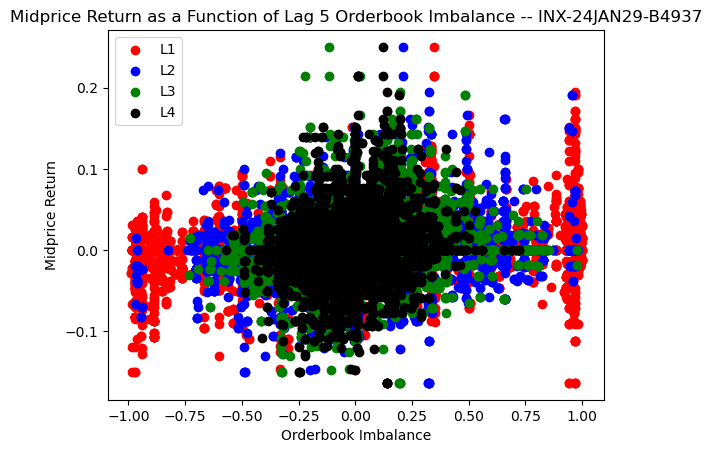

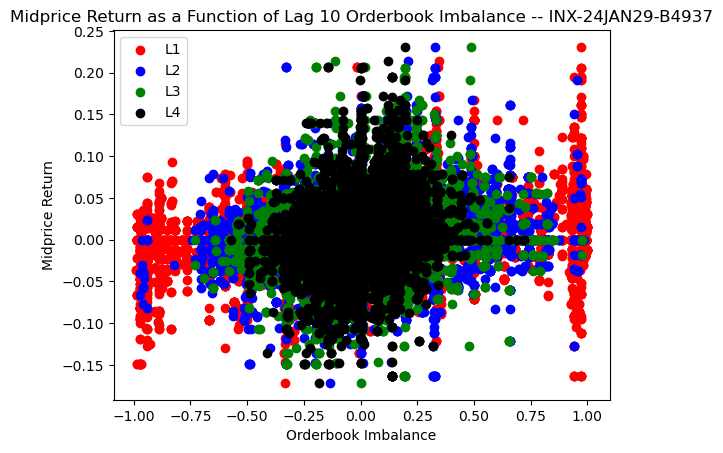

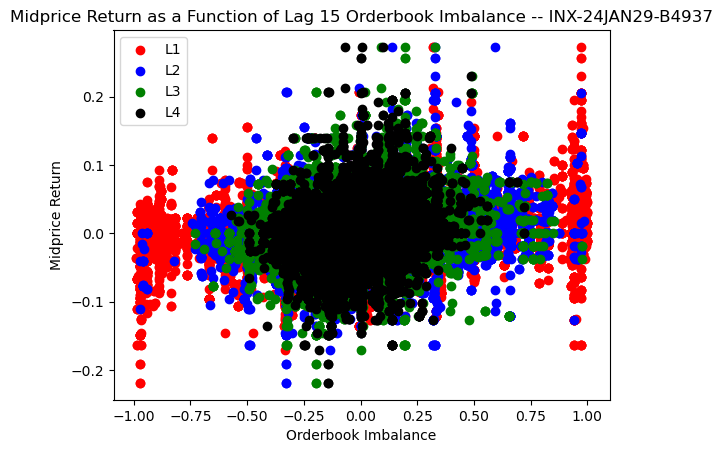

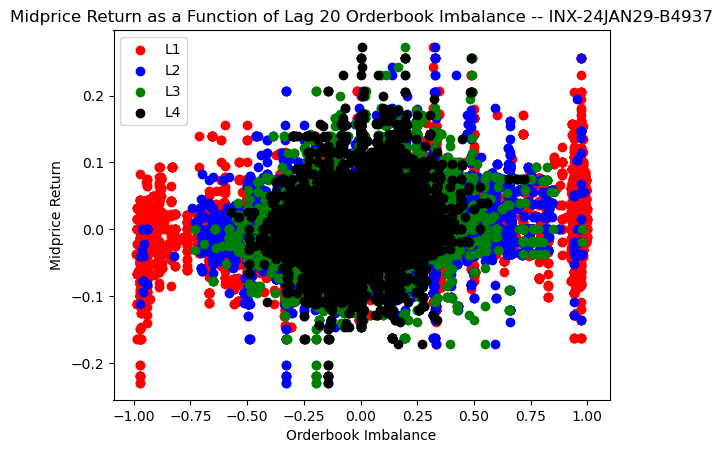

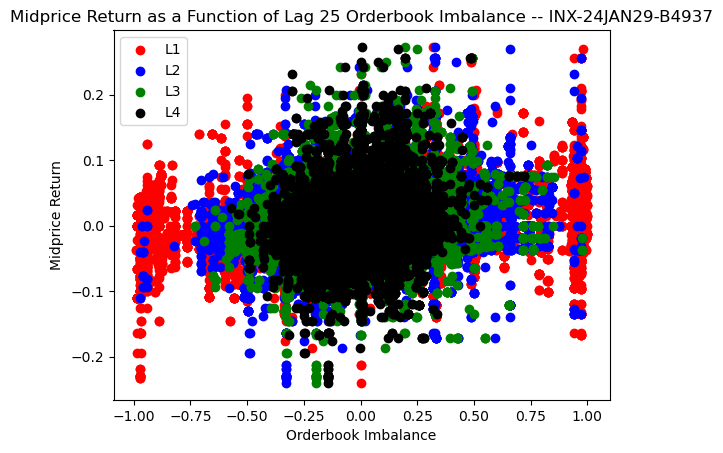

In [110]:
sp500_l1_obi = data[data['ticker']==sp500_ticker]['obi_l1'].tolist()
sp500_l2_obi = data[data['ticker']==sp500_ticker]['obi_l2'].tolist()
sp500_l3_obi = data[data['ticker']==sp500_ticker]['obi_l3'].tolist()
sp500_l4_obi = data[data['ticker']==sp500_ticker]['obi_l4'].tolist()
sp500_midpoint = data[data['ticker']==sp500_ticker]['midpoint'].tolist()

for lookahead_period in [5, 10, 15, 20, 25]:
    plt.figure()
    l1_x = sp500_l1_obi[:len(sp500_midpoint)-lookahead_period]
    l2_x = sp500_l2_obi[:len(sp500_midpoint)-lookahead_period]
    l3_x = sp500_l3_obi[:len(sp500_midpoint)-lookahead_period]
    l4_x = sp500_l4_obi[:len(sp500_midpoint)-lookahead_period]
    y = (np.array(sp500_midpoint[lookahead_period:])-np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period]))/np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period])
    
    plt.scatter(l1_x, y, color='red', label = 'L1')
    plt.scatter(l2_x, y, color='blue', label = 'L2')
    plt.scatter(l3_x, y, color='green', label = 'L3')
    plt.scatter(l4_x, y, color='black', label = 'L4')
    
    plt.legend()
    plt.xlabel('Orderbook Imbalance')
    plt.ylabel('Midprice Return')
    plt.title('Midprice Return as a Function of Lag {} Orderbook Imbalance -- {}'.format(str(lookahead_period), sp500_ticker))
    plt.show()
    

        


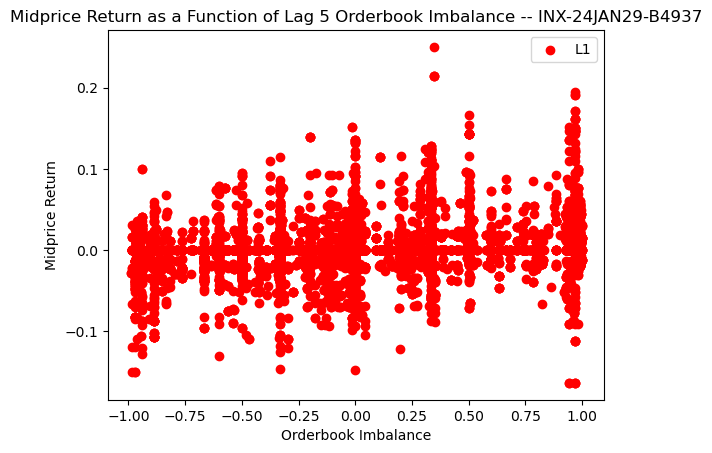

In [89]:
for lookahead_period in [5]:#, 10, 15, 20, 25]:
    plt.figure()
    l1_x = sp500_l1_obi[:len(sp500_midpoint)-lookahead_period]
    l2_x = sp500_l2_obi[:len(sp500_midpoint)-lookahead_period]
    l3_x = sp500_l3_obi[:len(sp500_midpoint)-lookahead_period]
    l4_x = sp500_l4_obi[:len(sp500_midpoint)-lookahead_period]
    y = (np.array(sp500_midpoint[lookahead_period:])-np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period]))/np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period])
    
    plt.scatter(l1_x, y, color='red', label = 'L1')
    #plt.scatter(l2_x, y, color='blue', label = 'L2')
    #plt.scatter(l3_x, y, color='green', label = 'L3')
    #plt.scatter(l4_x, y, color='black', label = 'L4')
    
    plt.legend()
    plt.xlabel('Orderbook Imbalance')
    plt.ylabel('Midprice Return')
    plt.title('Midprice Return as a Function of Lag {} Orderbook Imbalance -- {}'.format(str(lookahead_period), sp500_ticker))
    plt.show()

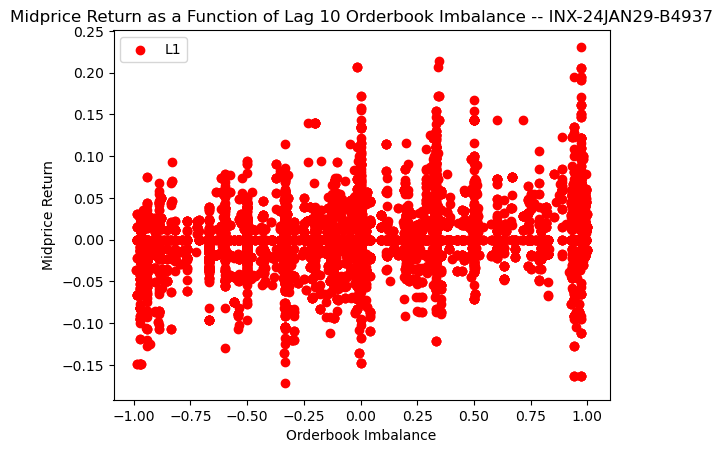

In [90]:
for lookahead_period in [10]:#, 10, 15, 20, 25]:
    plt.figure()
    l1_x = sp500_l1_obi[:len(sp500_midpoint)-lookahead_period]
    l2_x = sp500_l2_obi[:len(sp500_midpoint)-lookahead_period]
    l3_x = sp500_l3_obi[:len(sp500_midpoint)-lookahead_period]
    l4_x = sp500_l4_obi[:len(sp500_midpoint)-lookahead_period]
    y = (np.array(sp500_midpoint[lookahead_period:])-np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period]))/np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period])
    
    plt.scatter(l1_x, y, color='red', label = 'L1')
    #plt.scatter(l2_x, y, color='blue', label = 'L2')
    #plt.scatter(l3_x, y, color='green', label = 'L3')
    #plt.scatter(l4_x, y, color='black', label = 'L4')
    
    plt.legend()
    plt.xlabel('Orderbook Imbalance')
    plt.ylabel('Midprice Return')
    plt.title('Midprice Return as a Function of Lag {} Orderbook Imbalance -- {}'.format(str(lookahead_period), sp500_ticker))
    plt.show()

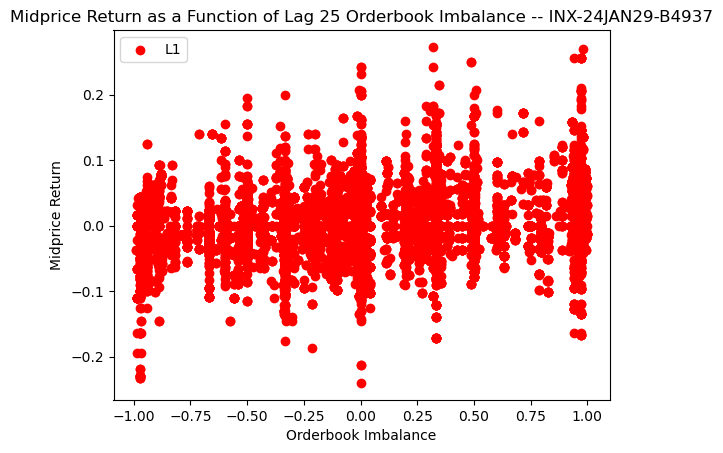

In [91]:
for lookahead_period in [25]:#, 10, 15, 20, 25]:
    plt.figure()
    l1_x = sp500_l1_obi[:len(sp500_midpoint)-lookahead_period]
    l2_x = sp500_l2_obi[:len(sp500_midpoint)-lookahead_period]
    l3_x = sp500_l3_obi[:len(sp500_midpoint)-lookahead_period]
    l4_x = sp500_l4_obi[:len(sp500_midpoint)-lookahead_period]
    y = (np.array(sp500_midpoint[lookahead_period:])-np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period]))/np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period])
    
    plt.scatter(l1_x, y, color='red', label = 'L1')
    #plt.scatter(l2_x, y, color='blue', label = 'L2')
    #plt.scatter(l3_x, y, color='green', label = 'L3')
    #plt.scatter(l4_x, y, color='black', label = 'L4')
    
    plt.legend()
    plt.xlabel('Orderbook Imbalance')
    plt.ylabel('Midprice Return')
    plt.title('Midprice Return as a Function of Lag {} Orderbook Imbalance -- {}'.format(str(lookahead_period), sp500_ticker))
    plt.show()

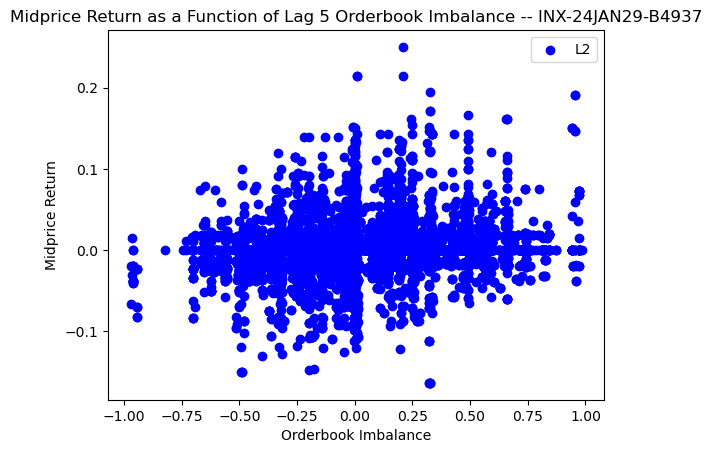

In [92]:
for lookahead_period in [5]:#, 10, 15, 20, 25]:
    plt.figure()
    l1_x = sp500_l1_obi[:len(sp500_midpoint)-lookahead_period]
    l2_x = sp500_l2_obi[:len(sp500_midpoint)-lookahead_period]
    l3_x = sp500_l3_obi[:len(sp500_midpoint)-lookahead_period]
    l4_x = sp500_l4_obi[:len(sp500_midpoint)-lookahead_period]
    y = (np.array(sp500_midpoint[lookahead_period:])-np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period]))/np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period])
    
    #plt.scatter(l1_x, y, color='red', label = 'L1')
    plt.scatter(l2_x, y, color='blue', label = 'L2')
    #plt.scatter(l3_x, y, color='green', label = 'L3')
    #plt.scatter(l4_x, y, color='black', label = 'L4')
    
    plt.legend()
    plt.xlabel('Orderbook Imbalance')
    plt.ylabel('Midprice Return')
    plt.title('Midprice Return as a Function of Lag {} Orderbook Imbalance -- {}'.format(str(lookahead_period), sp500_ticker))
    plt.show()

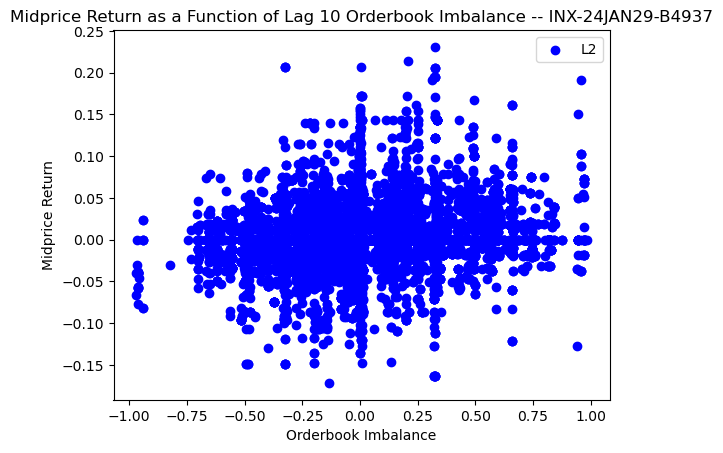

In [94]:
for lookahead_period in [10]:#, 10, 15, 20, 25]:
    plt.figure()
    l1_x = sp500_l1_obi[:len(sp500_midpoint)-lookahead_period]
    l2_x = sp500_l2_obi[:len(sp500_midpoint)-lookahead_period]
    l3_x = sp500_l3_obi[:len(sp500_midpoint)-lookahead_period]
    l4_x = sp500_l4_obi[:len(sp500_midpoint)-lookahead_period]
    y = (np.array(sp500_midpoint[lookahead_period:])-np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period]))/np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period])
    
    #plt.scatter(l1_x, y, color='red', label = 'L1')
    plt.scatter(l2_x, y, color='blue', label = 'L2')
    #plt.scatter(l3_x, y, color='green', label = 'L3')
    #plt.scatter(l4_x, y, color='black', label = 'L4')
    
    plt.legend()
    plt.xlabel('Orderbook Imbalance')
    plt.ylabel('Midprice Return')
    plt.title('Midprice Return as a Function of Lag {} Orderbook Imbalance -- {}'.format(str(lookahead_period), sp500_ticker))
    plt.show()

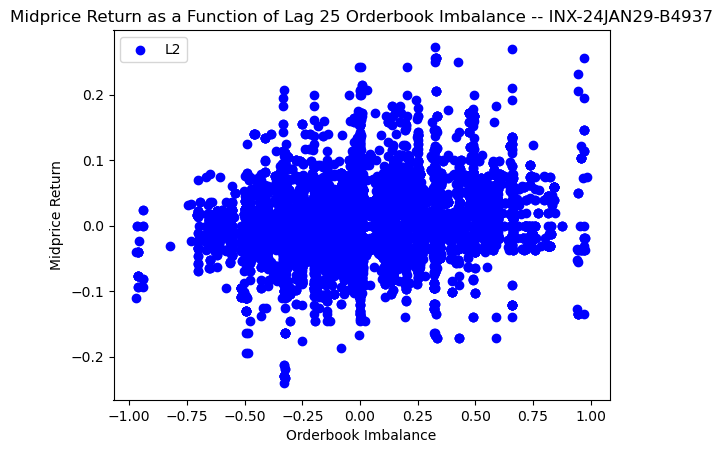

In [95]:
for lookahead_period in [25]:#, 10, 15, 20, 25]:
    plt.figure()
    l1_x = sp500_l1_obi[:len(sp500_midpoint)-lookahead_period]
    l2_x = sp500_l2_obi[:len(sp500_midpoint)-lookahead_period]
    l3_x = sp500_l3_obi[:len(sp500_midpoint)-lookahead_period]
    l4_x = sp500_l4_obi[:len(sp500_midpoint)-lookahead_period]
    y = (np.array(sp500_midpoint[lookahead_period:])-np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period]))/np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period])
    
    #plt.scatter(l1_x, y, color='red', label = 'L1')
    plt.scatter(l2_x, y, color='blue', label = 'L2')
    #plt.scatter(l3_x, y, color='green', label = 'L3')
    #plt.scatter(l4_x, y, color='black', label = 'L4')
    
    plt.legend()
    plt.xlabel('Orderbook Imbalance')
    plt.ylabel('Midprice Return')
    plt.title('Midprice Return as a Function of Lag {} Orderbook Imbalance -- {}'.format(str(lookahead_period), sp500_ticker))
    plt.show()

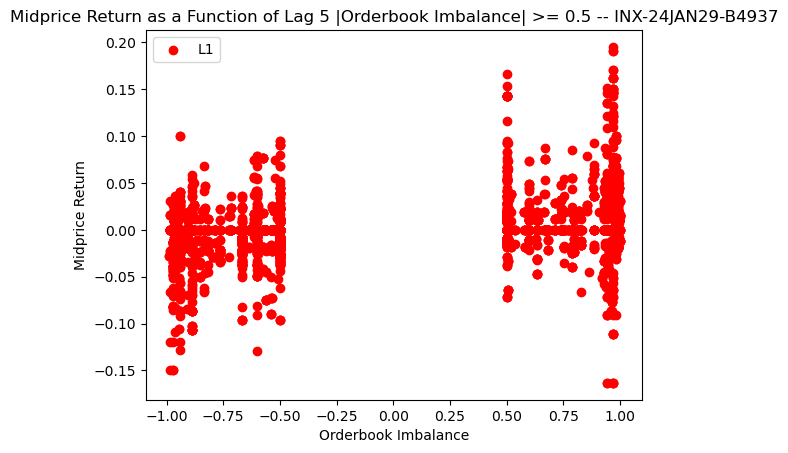

[[1.         0.21572616]
 [0.21572616 1.        ]]


In [121]:
for lookahead_period in [5]:#, 10, 15, 20, 25]:
    plt.figure()
    l1_x_temp = sp500_l1_obi[:len(sp500_midpoint)-lookahead_period]
    y_temp = (np.array(sp500_midpoint[lookahead_period:])-np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period]))/np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period])
    
    x = []
    y = []
    
    for i in range(len(l1_x_temp)):
        if abs(l1_x_temp[i]) >= 0.5:
            x.append(l1_x_temp[i])
            y.append(y_temp[i])
    
    plt.scatter(x, y, color='red', label = 'L1')
    #plt.scatter(l2_x, y, color='blue', label = 'L2')
    #plt.scatter(l3_x, y, color='green', label = 'L3')
    #plt.scatter(l4_x, y, color='black', label = 'L4')
    
    plt.legend()
    plt.xlabel('Orderbook Imbalance')
    plt.ylabel('Midprice Return')
    plt.title('Midprice Return as a Function of Lag {} |Orderbook Imbalance| >= 0.5 -- {}'.format(str(lookahead_period), sp500_ticker))
    plt.show()
    

    print(np.corrcoef(x, y))

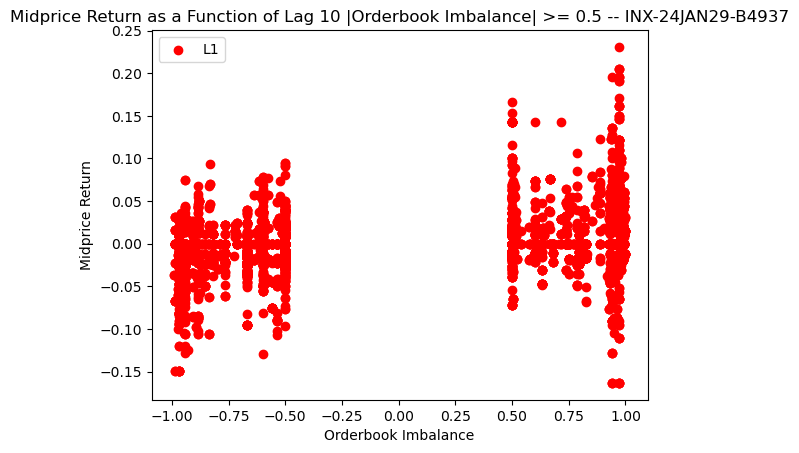

[[1.         0.25138174]
 [0.25138174 1.        ]]


In [122]:
for lookahead_period in [10]:#, 10, 15, 20, 25]:
    plt.figure()
    l1_x_temp = sp500_l1_obi[:len(sp500_midpoint)-lookahead_period]
    y_temp = (np.array(sp500_midpoint[lookahead_period:])-np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period]))/np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period])
    
    x = []
    y = []
    
    for i in range(len(l1_x_temp)):
        if abs(l1_x_temp[i]) >= 0.5:
            x.append(l1_x_temp[i])
            y.append(y_temp[i])
    
    plt.scatter(x, y, color='red', label = 'L1')
    #plt.scatter(l2_x, y, color='blue', label = 'L2')
    #plt.scatter(l3_x, y, color='green', label = 'L3')
    #plt.scatter(l4_x, y, color='black', label = 'L4')
    
    plt.legend()
    plt.xlabel('Orderbook Imbalance')
    plt.ylabel('Midprice Return')
    plt.title('Midprice Return as a Function of Lag {} |Orderbook Imbalance| >= 0.5 -- {}'.format(str(lookahead_period), sp500_ticker))
    plt.show()
    
    print(np.corrcoef(x, y))

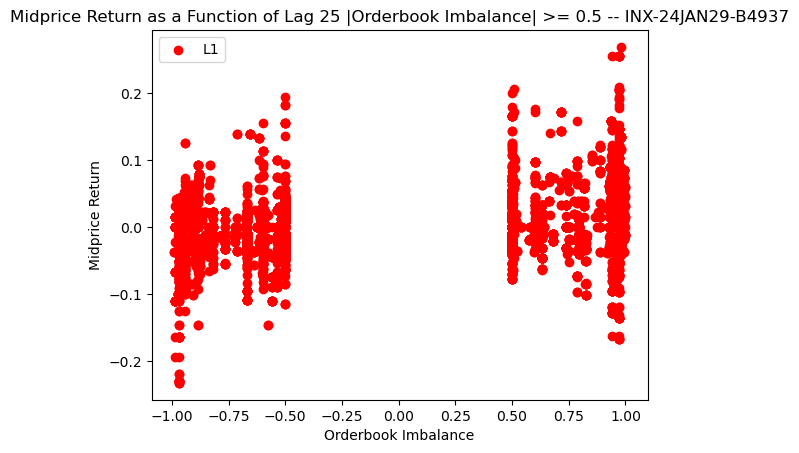

[[1.         0.28007918]
 [0.28007918 1.        ]]


In [123]:
for lookahead_period in [25]:#, 10, 15, 20, 25]:
    plt.figure()
    l1_x_temp = sp500_l1_obi[:len(sp500_midpoint)-lookahead_period]
    y_temp = (np.array(sp500_midpoint[lookahead_period:])-np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period]))/np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period])
    
    x = []
    y = []
    
    for i in range(len(l1_x_temp)):
        if abs(l1_x_temp[i]) >= 0.5:
            x.append(l1_x_temp[i])
            y.append(y_temp[i])
    
    plt.scatter(x, y, color='red', label = 'L1')
    #plt.scatter(l2_x, y, color='blue', label = 'L2')
    #plt.scatter(l3_x, y, color='green', label = 'L3')
    #plt.scatter(l4_x, y, color='black', label = 'L4')
    
    plt.legend()
    plt.xlabel('Orderbook Imbalance')
    plt.ylabel('Midprice Return')
    plt.title('Midprice Return as a Function of Lag {} |Orderbook Imbalance| >= 0.5 -- {}'.format(str(lookahead_period), sp500_ticker))
    plt.show()
    
    print(np.corrcoef(x, y))

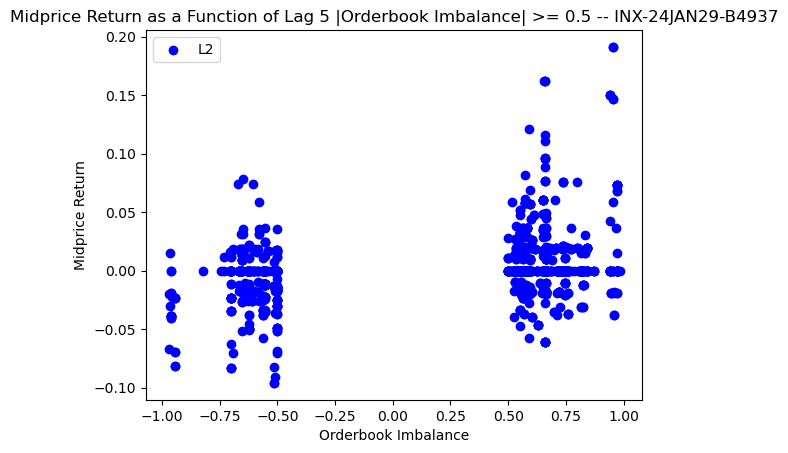

[[1.         0.29315361]
 [0.29315361 1.        ]]


In [124]:
for lookahead_period in [5]:#, 10, 15, 20, 25]:
    plt.figure()
    l2_x_temp = sp500_l2_obi[:len(sp500_midpoint)-lookahead_period]
    y_temp = (np.array(sp500_midpoint[lookahead_period:])-np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period]))/np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period])
    
    x = []
    y = []
    
    for i in range(len(l2_x_temp)):
        if abs(l2_x_temp[i]) >= 0.5:
            x.append(l2_x_temp[i])
            y.append(y_temp[i])
    
    #plt.scatter(x, y, color='red', label = 'L1')
    plt.scatter(x, y, color='blue', label = 'L2')
    #plt.scatter(l3_x, y, color='green', label = 'L3')
    #plt.scatter(l4_x, y, color='black', label = 'L4')
    
    plt.legend()
    plt.xlabel('Orderbook Imbalance')
    plt.ylabel('Midprice Return')
    plt.title('Midprice Return as a Function of Lag {} |Orderbook Imbalance| >= 0.5 -- {}'.format(str(lookahead_period), sp500_ticker))
    plt.show()
    
    print(np.corrcoef(x, y))

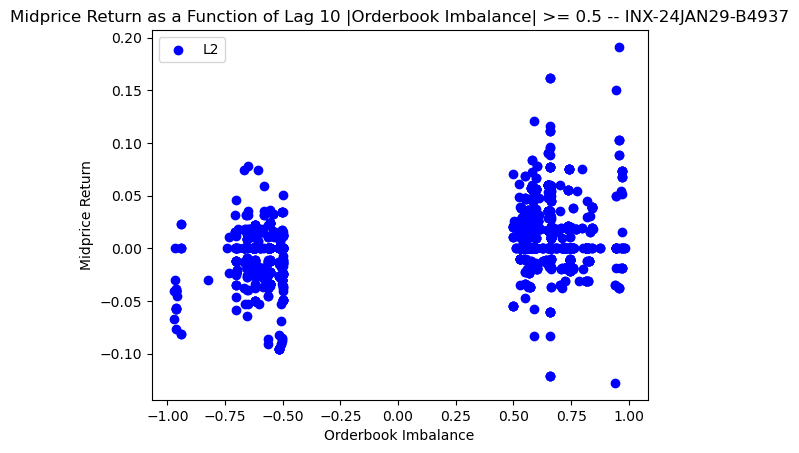

[[1.         0.34024531]
 [0.34024531 1.        ]]


In [125]:
for lookahead_period in [10]:#, 10, 15, 20, 25]:
    plt.figure()
    l2_x_temp = sp500_l2_obi[:len(sp500_midpoint)-lookahead_period]
    y_temp = (np.array(sp500_midpoint[lookahead_period:])-np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period]))/np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period])
    
    x = []
    y = []
    
    for i in range(len(l2_x_temp)):
        if abs(l2_x_temp[i]) >= 0.5:
            x.append(l2_x_temp[i])
            y.append(y_temp[i])
    
    #plt.scatter(x, y, color='red', label = 'L1')
    plt.scatter(x, y, color='blue', label = 'L2')
    #plt.scatter(l3_x, y, color='green', label = 'L3')
    #plt.scatter(l4_x, y, color='black', label = 'L4')
    
    plt.legend()
    plt.xlabel('Orderbook Imbalance')
    plt.ylabel('Midprice Return')
    plt.title('Midprice Return as a Function of Lag {} |Orderbook Imbalance| >= 0.5 -- {}'.format(str(lookahead_period), sp500_ticker))
    plt.show()
    
    print(np.corrcoef(x, y))

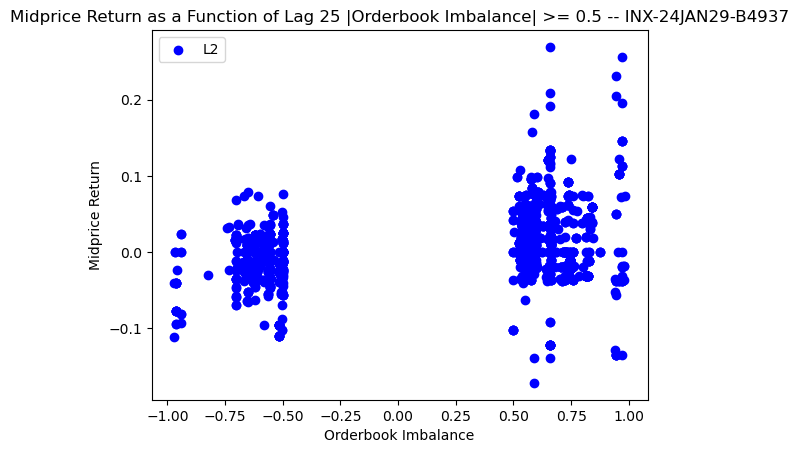

[[1.         0.34187758]
 [0.34187758 1.        ]]


In [126]:
for lookahead_period in [25]:#, 10, 15, 20, 25]:
    plt.figure()
    l2_x_temp = sp500_l2_obi[:len(sp500_midpoint)-lookahead_period]
    y_temp = (np.array(sp500_midpoint[lookahead_period:])-np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period]))/np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period])
    
    x = []
    y = []
    
    for i in range(len(l2_x_temp)):
        if abs(l2_x_temp[i]) >= 0.5:
            x.append(l2_x_temp[i])
            y.append(y_temp[i])
    
    #plt.scatter(x, y, color='red', label = 'L1')
    plt.scatter(x, y, color='blue', label = 'L2')
    #plt.scatter(l3_x, y, color='green', label = 'L3')
    #plt.scatter(l4_x, y, color='black', label = 'L4')
    
    plt.legend()
    plt.xlabel('Orderbook Imbalance')
    plt.ylabel('Midprice Return')
    plt.title('Midprice Return as a Function of Lag {} |Orderbook Imbalance| >= 0.5 -- {}'.format(str(lookahead_period), sp500_ticker))
    plt.show()
    
    print(np.corrcoef(x, y))

Still early days but it looks like orderbook imbalance may be a short-term predictive signal.. need to explore this more

In [127]:
ndx_l1_obi = data[data['ticker']==nasdaq_ticker]['obi_l1'].tolist()
ndx_l2_obi = data[data['ticker']==nasdaq_ticker]['obi_l2'].tolist()
ndx_l3_obi = data[data['ticker']==nasdaq_ticker]['obi_l3'].tolist()
ndx_l4_obi = data[data['ticker']==nasdaq_ticker]['obi_l4'].tolist()
ndx_midpoint = data[data['ticker']==nasdaq_ticker]['midpoint'].tolist()

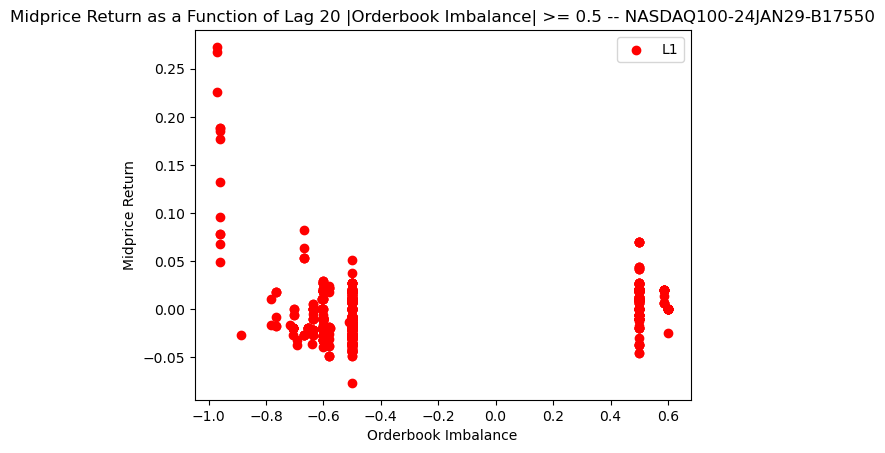

[[1.         0.09348155]
 [0.09348155 1.        ]]


In [142]:
for lookahead_period in [20]:#, 10, 15, 20, 25]:
    plt.figure()
    l1_x_temp = ndx_l1_obi[:len(ndx_midpoint)-lookahead_period]
    y_temp = (np.array(ndx_midpoint[lookahead_period:])-np.array(ndx_midpoint[:len(ndx_midpoint)-lookahead_period]))/np.array(ndx_midpoint[:len(ndx_midpoint)-lookahead_period])
    
    x = []
    y = []
    
    for i in range(len(l1_x_temp)):
        if abs(l1_x_temp[i]) >= 0.5:
            x.append(l1_x_temp[i])
            y.append(y_temp[i])
    
    plt.scatter(x, y, color='red', label = 'L1')
    #plt.scatter(l2_x, y, color='blue', label = 'L2')
    #plt.scatter(l3_x, y, color='green', label = 'L3')
    #plt.scatter(l4_x, y, color='black', label = 'L4')
    
    plt.legend()
    plt.xlabel('Orderbook Imbalance')
    plt.ylabel('Midprice Return')
    plt.title('Midprice Return as a Function of Lag {} |Orderbook Imbalance| >= 0.5 -- {}'.format(str(lookahead_period), nasdaq_ticker))
    plt.show()
    

    print(np.corrcoef(x, y))

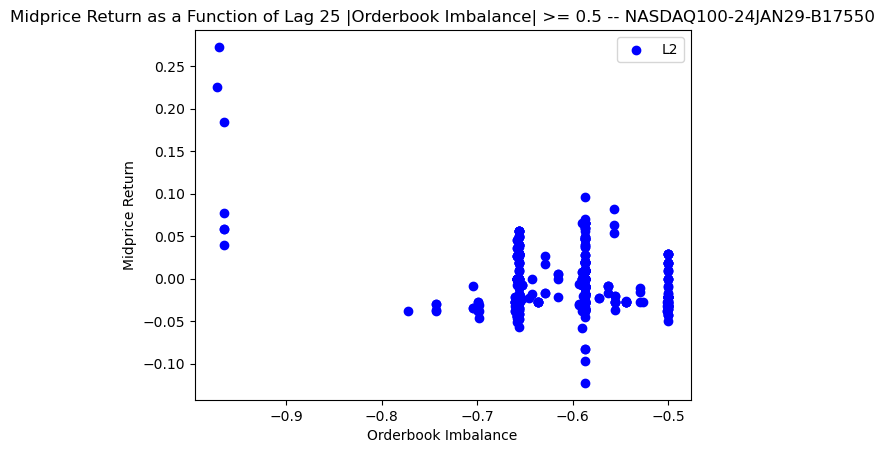

[[ 1.         -0.29476002]
 [-0.29476002  1.        ]]


In [140]:
for lookahead_period in [25]:#, 10, 15, 20, 25]:
    plt.figure()
    l2_x_temp = ndx_l2_obi[:len(ndx_midpoint)-lookahead_period]
    y_temp = (np.array(ndx_midpoint[lookahead_period:])-np.array(ndx_midpoint[:len(ndx_midpoint)-lookahead_period]))/np.array(ndx_midpoint[:len(ndx_midpoint)-lookahead_period])
    
    x = []
    y = []
    
    for i in range(len(l2_x_temp)):
        if abs(l2_x_temp[i]) >= 0.5:
            x.append(l2_x_temp[i])
            y.append(y_temp[i])
    
    #plt.scatter(x, y, color='red', label = 'L1')
    plt.scatter(x, y, color='blue', label = 'L2')
    #plt.scatter(l3_x, y, color='green', label = 'L3')
    #plt.scatter(l4_x, y, color='black', label = 'L4')
    
    plt.legend()
    plt.xlabel('Orderbook Imbalance')
    plt.ylabel('Midprice Return')
    plt.title('Midprice Return as a Function of Lag {} |Orderbook Imbalance| >= 0.5 -- {}'.format(str(lookahead_period), nasdaq_ticker))
    plt.show()
    

    print(np.corrcoef(x, y))

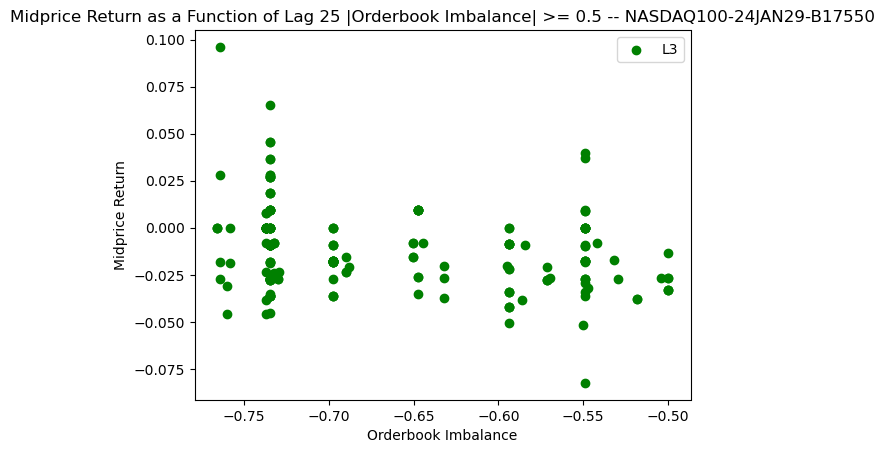

[[ 1.         -0.27357817]
 [-0.27357817  1.        ]]


In [139]:
for lookahead_period in [25]:#, 10, 15, 20, 25]:
    plt.figure()
    l3_x_temp = ndx_l3_obi[:len(ndx_midpoint)-lookahead_period]
    y_temp = (np.array(ndx_midpoint[lookahead_period:])-np.array(ndx_midpoint[:len(ndx_midpoint)-lookahead_period]))/np.array(ndx_midpoint[:len(ndx_midpoint)-lookahead_period])
    
    x = []
    y = []
    
    for i in range(len(l3_x_temp)):
        if abs(l3_x_temp[i]) >= 0.5:
            x.append(l3_x_temp[i])
            y.append(y_temp[i])
    
    #plt.scatter(x, y, color='red', label = 'L1')
    #plt.scatter(x, y, color='blue', label = 'L2')
    plt.scatter(x, y, color='green', label = 'L3')
    #plt.scatter(l4_x, y, color='black', label = 'L4')
    
    plt.legend()
    plt.xlabel('Orderbook Imbalance')
    plt.ylabel('Midprice Return')
    plt.title('Midprice Return as a Function of Lag {} |Orderbook Imbalance| >= 0.5 -- {}'.format(str(lookahead_period), nasdaq_ticker))
    plt.show()
    

    print(np.corrcoef(x, y))

The NASDAQ data on 1/29/24 seems to point to no correlation between orderbook imbalance and future returns although it could be a sample size idiosyncracy as only looking at L1 orderbook imbalance includes positive large imbalance values at all.